In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pickle
import numpy as np
from scipy.optimize import curve_fit

import crflux.models as pm

import  mceq_underground_helper_forsplines as helper

from helper_functions import sl_depth
import seaborn as sns

In [3]:
# for plotting

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

colors = sns.color_palette("colorblind")

plot_dir = '/hetghome/khymon/Plots/cs-analysis/'

In [4]:
def dNdN_mu(d, n_mu, p1, p2, p3):
    '''
        Get multiplicity intensity spectrum in cm-2 s-1 sr-1
        p1, p2, p3: float 
        n_mu: multiplicity vector for which dNdNmu is calculated
    '''
    
    angle = 0.
    X = sl_depth(d,angle)
    season = "apr"
    threshold = 500.

    return 1e4*helper.mult_dist(X, angle,
                        pm.GlobalSplineFitBeta(),"yields_" + season, 
                        p1, p2,p3,n_mu,
                        norm=False,threshold=threshold#))[0]
                    ) / helper.rates(X, angle, season, p1, p2, p3, threshold)

In [5]:
def derivative(param,d,n_mu):
    ''' Calculate derviate dNdNmu/dmu for each spline parameter
        param: string
        n_mu: multiplicity grid
    '''
    if param =='p1':
        delta_dNdNmu = dNdN_mu(d, n_mu, 0.05, 0., 0.) - dNdN_mu(d, n_mu,-0.05, 0., 0.)
    elif param =='p2':
        delta_dNdNmu = dNdN_mu(d, n_mu, 0.0, 0.05, 0.) - dNdN_mu(d, n_mu, 0., -0.05, 0.)
    elif param =='p3':
        delta_dNdNmu = dNdN_mu(d, n_mu, 0.0, 0., 0.05) - dNdN_mu(d, n_mu, 0., 0., 0.05)

    return delta_dNdNmu/(2*0.05)

In [6]:
# initialize helper - loads respective surace flux files

p1_values = [0.00, 0.05, -0.05, 0.00,  0.00, 0.00, 0.00]
p2_values = [0.00, 0.00,  0.00, 0.05, -0.05, 0.00, 0.00]
p3_values = [0.00, 0.00,  0.00, 0.00,  0.00, 0.05, -0.05]
season_values = ["jan", "apr", "jul"]  #  seasons



helper.initialize_flux_dicts(p1_values, p2_values, p3_values)
helper.some_function_that_uses_angles()
angles = helper.angles

Key: (0.0, 0.0, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.05, 0.0, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (-0.05, 0.0, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.0, 0.05, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.0, -0.05, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.0, 0.0, 0.05)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.0, 0.0, -0.05

In [7]:
d = [1.5, 2.5]
angles = helper.angles
Nmu =  np.linspace(1, 100, 101) # 

In [8]:

m_test = np.linspace(3, 300, 101) 

dNdN_mu(1.5, m_test, 0.05, 0., 0.)/dNdN_mu(1.5, Nmu,0.05, 0., 0.)

array([0.02069899, 0.01652536, 0.01371603, 0.0124227 , 0.01209741,
       0.01230516, 0.01279795, 0.01339121, 0.01402032, 0.01460808,
       0.01532415, 0.01583928, 0.01627999, 0.01661892, 0.01694276,
       0.01728614, 0.0174101 , 0.01759244, 0.01773968, 0.01791961,
       0.01799982, 0.01806911, 0.01812449, 0.01823022, 0.01821076,
       0.01823933, 0.01826373, 0.01828535, 0.01842155, 0.0183395 ,
       0.01835427, 0.01836918, 0.01838437, 0.01839993, 0.01840668,
       0.01842407, 0.01839827, 0.01842055, 0.01844335, 0.01846671,
       0.0184907 , 0.01862182, 0.01863965, 0.01862874, 0.01865102,
       0.01867459, 0.01869943, 0.01872552, 0.01875281, 0.01878127,
       0.01890255, 0.01892761, 0.01895383, 0.01891985, 0.01895165,
       0.01898443, 0.01901815, 0.0190528 , 0.01908833, 0.01912473,
       0.01916892, 0.01920663, 0.01924513, 0.01928439, 0.01931911,
       0.01936007, 0.01940173, 0.01944407, 0.01948706, 0.01953068,
       0.01957492, 0.01961977, 0.0196652 , 0.0197652 , 0.01980

In [10]:
#calculate derivatesfor all angles and depths, array structure #shape=(depth,angle,multiplicities)

dNdNmu_da = np.ndarray(shape=(len(d), len(Nmu)))
dNdNmu_db = np.ndarray(shape=(len(d), len(Nmu)))
dNdNmu_dc = np.ndarray(shape=(len(d), len(Nmu)))

for i in range(len(d)):
    dNdNmu_da[i] = derivative("p1",d[i], Nmu)
    dNdNmu_db[i] = derivative("p2",d[i], Nmu)
    dNdNmu_dc[i] = derivative("p3",d[i], Nmu)


In [11]:
# get total derviative

a = 0.05
b = 0.05
c = 0.05

dNdNmu_def = np.ndarray(shape=(len(d), len(Nmu)))
for i in range(len(d)):
    dNdNmu_def[i] = dNdN_mu(d[i], Nmu, 0., 0., 0.)
dNdNmu_mod = dNdNmu_def + dNdNmu_da * a  + dNdNmu_db * b + dNdNmu_dc * c

In [12]:
# create function forone depth and angle that can be fitted
# returns dNdNmu/dmu in log10

a = 0.05
b = 0.05
c = 0.05

def f_mod(d, a,b,c, n_mu):
    
    dNdNmu_da = derivative("p1",d,n_mu)
    dNdNmu_db = derivative("p2",d,n_mu)
    dNdNmu_dc = derivative("p3",d,n_mu)

    dNdNmu_def = dNdN_mu(d, n_mu, 0., 0., 0.)
    
    return np.log10(dNdNmu_def + dNdNmu_da * a  + dNdNmu_db * b + dNdNmu_dc * c)

In [13]:
dNdNmu_mod_00 = f_mod(d=1.5,n_mu=Nmu,a=0.05,b=0.05,c=0.05) # in log - index is the depth, 0 = 1.5km, 1 = 2.5km
dNdNmu_mod_10 = f_mod(d=2.5,n_mu=Nmu,a=0.05,b=0.05,c=0.05)



In [14]:
dNdNmu_mod_10

array([ -3.42619739,  -4.53272196,  -5.23116433,  -5.74089738,
        -6.13865183,  -6.45617457,  -6.71903497,  -6.94224088,
        -7.13682785,  -7.30741741,  -7.46203557,  -7.60087706,
        -7.730916  ,  -7.84812565,  -7.95721981,  -8.059353  ,
        -8.15541361,  -8.24748557,  -8.33422744,  -8.41537714,
        -8.49267758,  -8.56889084,  -8.63897838,  -8.7062948 ,
        -8.77090331,  -8.83300766,  -8.89328171,  -8.95068543,
        -9.00625578,  -9.05994475,  -9.11187137,  -9.16281071,
        -9.21277828,  -9.25916129,  -9.3049102 ,  -9.34935506,
        -9.39256809,  -9.43461611,  -9.47668666,  -9.51875712,
        -9.55619581,  -9.59398233,  -9.63087095,  -9.66690333,
        -9.7021183 ,  -9.7365521 ,  -9.77086427,  -9.80506587,
        -9.83655358,  -9.86810455,  -9.89902555,  -9.92934129,
        -9.95907436,  -9.98824501, -10.01687215, -10.0449742 ,
       -10.07298785, -10.10137678, -10.12749337, -10.15316047,
       -10.17884189, -10.20409233, -10.2289249 , -10.25

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1908796/1493693591.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel("log (dN/dN$_\mu$ / (s cm$^2$ sr)$^{-1})$")
/tmp/ipykernel_1908796/1493693591.py:36: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_xlabel('log($N_{\mu}$)')


<Figure size 4135x3101.25 with 0 Axes>

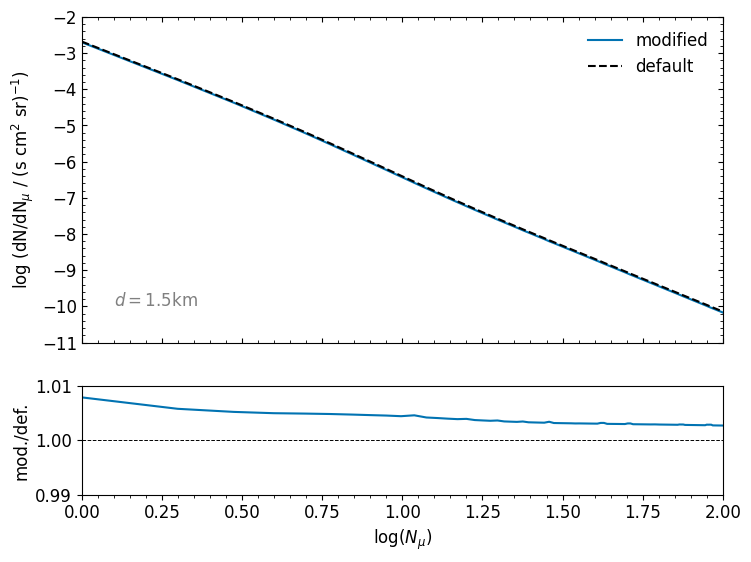

<Figure size 640x480 with 0 Axes>

<Figure size 4135x3101.25 with 0 Axes>

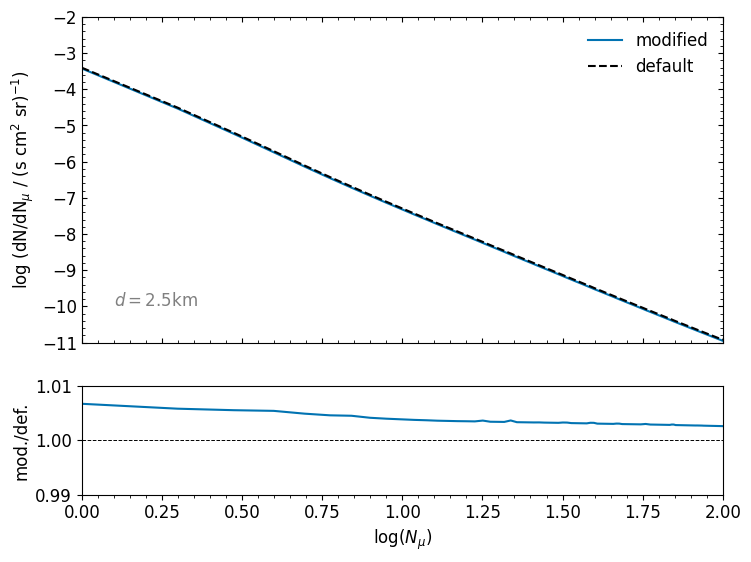

<Figure size 640x480 with 0 Axes>

In [23]:
# plot multiplicity spectrum for angle = 0., d=1.5km in log log

A4_width_inches = 8.27  # Width of A4 paper in inches
A4_height_inches = A4_width_inches * 0.75 # Height is one-third of width
figsize = (A4_width_inches, A4_height_inches)

for i in range(len(d)):

    # Create subplots using GridSpec
    fig = plt.figure(figsize=figsize, dpi=500)
    fig.tight_layout(pad=0.4)

    # Create a gridspec with 2 rows and 1 column, where the second row will be narrow
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(A4_width_inches, A4_height_inches), sharex=True, height_ratios=[3,1 ])

    # Plot lines with labels (same as before)
    ax1.plot(np.log10(Nmu), np.log10(dNdNmu_mod[i]), color=colors[0], label=r'modified')
    ax1.plot(np.log10(Nmu), np.log10(dNdNmu_def[i]), color='black', label=r'default',ls='--')

    ax1.set_ylim(-11,-2)

    ax1.set_ylabel("log (dN/dN$_\mu$ / (s cm$^2$ sr)$^{-1})$")
    plt.setp(ax1.get_xticklabels(), visible=False) 


    ax1.minorticks_on()
    ax1.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
    ax1.tick_params(axis='y', which='both', direction='in', left=True, right=True)

    ax1.legend( loc='upper right', frameon=False)
    ax1.text(0.1, -10, '$d=$' +str(d[i])+  'km' , fontsize=12, color='grey')

    ax2.plot(np.log10(Nmu), np.log10(dNdNmu_mod[i])/np.log10(dNdNmu_def[i]),  color=colors[0])
    ax2.plot([0.,2.],[1,1], lw=0.7, ls="--",color='black')

    ax2.set_xlabel('log($N_{\mu}$)')
    ax2.set_ylabel('mod./def.')
    ax2.set_ylim(0.99,1.01)
    ax2.set_xlim(0,2)


    # Save the figure
    plt.savefig(plot_dir+ "dNdNmu_def_vs_mod_0.05abc_depth" + str(d[i])+"km.pdf", bbox_inches='tight')
    plt.show()
    plt.clf()

In [16]:
#interpolate error from IceCube muon muplicity paper
# x-values (multiplicity given in absolute log10(N))

x_known = np.array([0.6,1.,1.5,2.])    
sigma_known = np.array([0.18, 0.14, 0.1, 0.08])  # observed uncertainties

# Define power-law model for sigma
def sigma_model(x, a, b):
    x = np.asarray(x)
    func = np.where(x < 0.5, 0.25, a * x**b)
    return func

# Fit model to known uncertainties
popt, _ = curve_fit(sigma_model, x_known, sigma_known)
a_fit, b_fit = popt

# Predict uncertainties for all multiplicities 
sigma_all = sigma_model(np.log10(Nmu), a_fit, b_fit)


/tmp/ipykernel_1908796/88444011.py:10: RuntimeWarning: divide by zero encountered in power
  func = np.where(x < 0.5, 0.25, a * x**b)


In [17]:
sigma_all

array([0.25      , 0.25      , 0.25      , 0.18347187, 0.16656558,
       0.15538067, 0.14729226, 0.14109437, 0.13614798, 0.13207971,
       0.12865522, 0.12571919, 0.12316412, 0.12091298, 0.11890893,
       0.11710901, 0.11548005, 0.113996  , 0.11263607, 0.11138343,
       0.11022431, 0.10914728, 0.10814282, 0.10720287, 0.1063206 ,
       0.10549014, 0.10470643, 0.10396511, 0.10326234, 0.10259477,
       0.10195945, 0.10135376, 0.10077538, 0.10022223, 0.09969246,
       0.09918439, 0.09869652, 0.09822748, 0.09777605, 0.0973411 ,
       0.09692161, 0.09651663, 0.09612532, 0.09574689, 0.0953806 ,
       0.0950258 , 0.09468186, 0.09434823, 0.09402435, 0.09370976,
       0.09340398, 0.09310659, 0.09281721, 0.09253545, 0.09226096,
       0.09199344, 0.09173256, 0.09147805, 0.09122964, 0.09098707,
       0.0907501 , 0.09051852, 0.0902921 , 0.09007066, 0.08985399,
       0.08964193, 0.08943429, 0.08923093, 0.08903168, 0.08883641,
       0.08864497, 0.08845723, 0.08827307, 0.08809238, 0.08791

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1908796/3306530509.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('log($N_{\mu}$)')
/tmp/ipykernel_1908796/3306530509.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Absolute Error log($N_{\mu}$)')


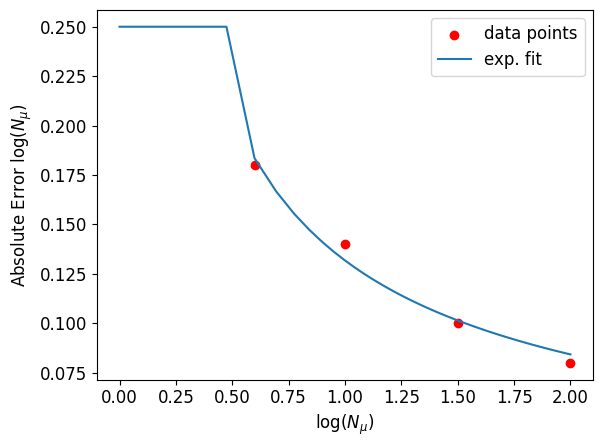

In [18]:
# test plot for interpolation

plt.scatter(x_known,sigma_known,label='data points',color='red')
plt.plot(np.log10(Nmu),sigma_all,label='exp. fit')
plt.xlabel('log($N_{\mu}$)')
plt.ylabel('Absolute Error log($N_{\mu}$)')
plt.legend()

In [42]:
# propagate error to dNdNmu


def propagate_error_via_gradient(f, x, x_err, dx=1e-6):
    def finite_diff(f, x, i, dx):
        x = np.array(x, copy=True)
        x_fwd = x.copy()
        x_bwd = x.copy()
        
        if i == 0:
            # Forward difference at start
            x_fwd[i] += dx
            return (f(x_fwd)[i] - f(x)[i]) / dx
        elif i == len(x) - 1:
            # Backward difference at end
            x_bwd[i] -= dx
            return (f(x)[i] - f(x_bwd)[i]) / dx
        else:
            # Central difference
            x_fwd[i] += dx
            x_bwd[i] -= dx
            return (f(x_fwd)[i] - f(x_bwd)[i]) / (2 * dx)

    dfdx = np.array([finite_diff(f, x, i, dx) for i in range(len(x))])
    return np.abs(dfdx) * x_err


def f_wrapped(Nmu):
    a = 0.05
    b = 0.05
    c = 0.05
    return f_mod(1.5, a, b, c, Nmu)

In [33]:
x_err_lin = Nmu * np.log(10) * sigma_all
x_err_lin

array([ 0.57564627,  1.14553608,  1.71542589,  1.67716461,  1.90231586,
        2.12877445,  2.35372151,  2.57631261,  2.79635145,  3.01387648,
        3.22901151,  3.4419068 ,  3.65271482,  3.86158045,  4.06863737,
        4.27400734,  4.47780051,  4.68011642,  4.88104495,  5.08066745,
        5.27905766,  5.47628258,  5.6724033 ,  5.8674756 ,  6.06155062,
        6.25467532,  6.44689295,  6.63824345,  6.82876379,  7.01848825,
        7.20744869,  7.39567483,  7.58319436,  7.7700332 ,  7.95621565,
        8.14176448,  8.32670111,  8.51104571,  8.69481729,  8.8780338 ,
        9.06071223,  9.24286862,  9.42451823,  9.60567551,  9.78635418,
        9.96656732, 10.14632736, 10.32564616, 10.50453502, 10.68300477,
       10.8610657 , 11.03872771, 11.21600025, 11.39289237, 11.56941278,
       11.7455698 , 11.92137144, 12.0968254 , 12.27193909, 12.44671962,
       12.62117385, 12.79530838, 12.9691296 , 13.14264364, 13.31585644,
       13.48877372, 13.66140102, 13.83374368, 14.00580689, 14.17

In [51]:
y_err_log = propagate_error_via_gradient(f_wrapped, Nmu, x_err_lin)

In [53]:
y_err_log

array([0.85959703, 0.87917653, 0.90815265, 0.68792982, 0.64625854,
       0.61635715, 0.59109561, 0.56990153, 0.55259043, 0.53451215,
       0.51742292, 0.50098288, 0.48720584, 0.47322343, 0.46198917,
       0.45090732, 0.44069261, 0.43201815, 0.42426317, 0.41527925,
       0.40982216, 0.40424439, 0.3992126 , 0.39280205, 0.38935897,
       0.38562861, 0.38223518, 0.37914322, 0.37295373, 0.37160309,
       0.36925743, 0.36708025, 0.36501596, 0.36306757, 0.36148975,
       0.35964549, 0.35799412, 0.35642764, 0.35493988, 0.35352539,
       0.35217915, 0.35001958, 0.34693396, 0.34675114, 0.34563981,
       0.34457438, 0.34353724, 0.34251157, 0.34150554, 0.34051883,
       0.33882087, 0.33632115, 0.33620775, 0.33529485, 0.33439776,
       0.33351605, 0.33264904, 0.33179633, 0.33095724, 0.33013147,
       0.32926756, 0.32841483, 0.32757421, 0.32684529, 0.32607952,
       0.32532477, 0.32458052, 0.32384637, 0.32312219, 0.32240754,
       0.32170226, 0.32100604, 0.32031857, 0.31926736, 0.31859

In [52]:
# fit optimal a, b ,c
def f_fit(Nmu, a, b, c):
    return f_mod(1.5, a, b, c, Nmu)


sigma_test = 0.1 * dNdNmu_mod_00 #(assuma 10% error)


popt, pcov = curve_fit(f_fit, np.log10(Nmu), dNdNmu_mod_10, p0=[0.05, 0.0, 0.0])


/hetghome/khymon/cs-analysis/IceCube_diffuse_underground_bundles/mceq_underground_helper_forsplines.py:494: RuntimeWarning: divide by zero encountered in log
  return np.exp(s_ecr(np.log(nmu)))
/hetghome/khymon/cs-analysis/IceCube_diffuse_underground_bundles/mceq_underground_helper_forsplines.py:502: RuntimeWarning: divide by zero encountered in log
  return np.exp(sd_ecr(np.log(nmu)))
/tmp/ipykernel_1908796/2155343901.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f_fit, np.log10(Nmu), dNdNmu_mod_10, p0=[0.05, 0.0, 0.0])


In [63]:
def log_model(logNmu, a, b, c):
    Nmu_linear = 10**logNmu
    return f_mod(1.5, a, b, c, Nmu_linear)

In [60]:
f_mod(1.5, a, b, c, Nmu)

array([ -2.70226402,  -3.74334235,  -4.37161459,  -4.83558901,
        -5.20624428,  -5.51860695,  -5.78807931,  -6.02339671,
        -6.23033558,  -6.41724146,  -6.58609387,  -6.73869947,
        -6.87660888,  -7.00481819,  -7.1215824 ,  -7.23094353,
        -7.33262799,  -7.42697633,  -7.5156401 ,  -7.60169253,
        -7.6796679 ,  -7.75460183,  -7.82594983,  -7.89642422,
        -7.96047578,  -8.02277177,  -8.08262255,  -8.14022822,
        -8.2002599 ,  -8.25182241,  -8.30338072,  -8.35330139,
        -8.40168932,  -8.44863856,  -8.49386681,  -8.53836552,
        -8.58150739,  -8.62351384,  -8.66444578,  -8.70435937,
        -8.74330646,  -8.78257957,  -8.82226326,  -8.85692202,
        -8.89227053,  -8.92686416,  -8.9607353 ,  -8.99391255,
        -9.02642263,  -9.05829124,  -9.09059982,  -9.12344709,
        -9.15212623,  -9.18153054,  -9.21040424,  -9.23876563,
        -9.26663208,  -9.2940201 ,  -9.32094537,  -9.34742282,
        -9.37354568,  -9.39924777,  -9.42453491,  -9.44

In [64]:
log_model(np.log10(Nmu), a, b, c)


array([ -2.70226402,  -3.74334235,  -4.37161459,  -4.83558901,
        -5.20624428,  -5.51860695,  -5.78807931,  -6.02339671,
        -6.23033558,  -6.41724146,  -6.58609387,  -6.73869947,
        -6.87660888,  -7.00481819,  -7.1215824 ,  -7.23094353,
        -7.33262799,  -7.42697633,  -7.5156401 ,  -7.60169253,
        -7.6796679 ,  -7.75460183,  -7.82594983,  -7.89642422,
        -7.96047578,  -8.02277177,  -8.08262255,  -8.14022822,
        -8.2002599 ,  -8.25182241,  -8.30338072,  -8.35330139,
        -8.40168932,  -8.44863856,  -8.49386681,  -8.53836552,
        -8.58150739,  -8.62351384,  -8.66444578,  -8.70435937,
        -8.74330646,  -8.78257957,  -8.82226326,  -8.85692202,
        -8.89227053,  -8.92686416,  -8.9607353 ,  -8.99391255,
        -9.02642263,  -9.05829124,  -9.09059982,  -9.12344709,
        -9.15212623,  -9.18153054,  -9.21040424,  -9.23876563,
        -9.26663208,  -9.2940201 ,  -9.32094537,  -9.34742282,
        -9.37354568,  -9.39924777,  -9.42453491,  -9.44

In [76]:
popt, pcov = curve_fit(
    log_model,
    np.log10(Nmu),
    dNdNmu_mod_00, p0=[0.,0.,0],
    sigma=sigma_test,
    absolute_sigma=True
  )

/tmp/ipykernel_1908796/1942927758.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


In [77]:
popt

array([0.05, 0.05, 0.  ])

In [78]:
pcov

array([[inf, inf, inf],
       [inf, inf, inf],
       [inf, inf, inf]])

In [82]:
from scipy.optimize import minimize

# Chi-squared function
def chi2(params, x, y, y_err):
    a, b,c  = params
    y_model = log_model(x, a, b,c)
    return np.sum(((y - y_model) / y_err)**2)

In [85]:
initial_guess = [0.1, 0.1,0.1]

# Call minimizer
result = minimize(chi2, initial_guess, args=(np.log10(Nmu), dNdNmu_mod_00, y_err_log))

# Best-fit parameters
popt = result.x

print("Best-fit parameters:", popt)
print("Chi2 at minimum:", result.fun)

Best-fit parameters: [0.04999997 0.04999885 0.1       ]
Chi2 at minimum: 4.9001289255677614e-14


In [86]:
from numpy.linalg import inv

# Numerical approximation of covariance matrix
if result.hess_inv is not None:
    try:
        pcov = result.hess_inv if isinstance(result.hess_inv, np.ndarray) else result.hess_inv.todense()
        perr = np.sqrt(np.diag(cov))
        print("Parameter uncertainties:", perr)
    except Exception as e:
        print("Covariance estimation failed:", e)

Parameter uncertainties: [0.08019337 4.24071148 1.        ]


In [88]:
# save files to folder
with open("/hetghome/khymon/cs-files/dNdNmu_fit-pi-air_d1.5km.pkl", "wb") as f:
    pickle.dump((popt, pcov), f)

In [ ]:
# test different fit methods

: 

In [ ]:
from scipy.odr import ODR,Model, RealData

# Define the ODR-compatible model
def odr_model(beta, x):
    a, b, c = beta
    return f_mod(1.5,  a, b, c, x)

data = RealData(np.log10(Nmu), dNdNmu_mod_00, sx=sigma_all)

model = Model(odr_model)
odr = ODR(data, model, beta0=[0.02, 0.03, 0.01])
output = odr.run()

: 

In [ ]:
popt = output.beta
pcov = output.cov_beta

: 

In [ ]:
pcov

array([[8.80829259e-02, 3.08666667e+00, 0.00000000e+00],
       [3.08666667e+00, 1.65294089e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

: 

In [ ]:
popt

array([0.05, 0.05, 0.01])

: 

In [ ]:
param_errors = np.sqrt(np.diag(output.cov_beta))
param_errors

array([ 0.29678768, 12.85667488,  0.        ])

: 